In [31]:
import os
import sys
import time
from datetime import date
from datetime import datetime
import time
import json
import platform
import pickle

#import stoneburner
#//*** Custom Functions:
#//*** mr_clean_text(input_series)
#//*** tokenize_series(input_series)
#//*** remove_stop_words(input_series)

# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
subreddits = ["wallstreetbets", "stocks", "wallstreetbetsOGs", "spacs", "investing", "pennystocks", "stockmarket", "options", "robinhoodpennystocks", "wallstreetbetsnew", "smallstreetbets"]
#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

#//*** Input_filename: Comments to Process.
#//*** This will eventually be a list of files
#input_filename  =".\\data\\wallstreetbets_comments.csv.zip"
interval="daily"
target_col = 'target_1'
#//*** Path to the stock ticker JSON file
stock_ticker_filename = "./data/stock_tickers.json"


results_df = pd.DataFrame(columns=['symbol','target','model','data','rmse','r2','actual','predict'])

#//*** Load the Stock Tickers
f = open(stock_ticker_filename, "r")
symbols = json.loads(f.read())['symbols']

#symbols = ["bb"]
f.close()

Look at Sparse PCA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html

install plaidml: https://towardsdatascience.com/plaidml-deep-learning-on-a-budget-ce22b58ba8c2

LTSM Code: https://medium.com/analytics-vidhya/beginners-guide-to-stock-prediction-using-lstm-7010bf8b8c21

Neural Networks for Regression: https://vitalflux.com/keras-neural-network-for-regression-problem/

Regression Metrics: https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
https://heartbeat.fritz.ai/linear-regression-using-keras-and-python-7cee2819a60c


https://towardsdatascience.com/walking-through-support-vector-regression-and-lstms-with-stock-price-prediction-45e11b620650

SGD Regression: https://www.kaggle.com/arpandas65/simple-sgd-implementation-of-linear-regression 

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

import time
from sklearn import linear_model

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD



In [3]:
try:
    from keras.models import Sequential

    #//*** Verify Plaid ML is working
    import plaidml.keras
    from sklearn.svm import SVR
    import os
    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

    plaidml.keras.install_backend()
    import tensorflow.keras
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers

    import tensorflow.keras.backend as K

    K
except:
    print("Trouble with Tensorflow")

Trouble with Tensorflow


['clov', 'sofi', 'wkhs', 'amd', 'gme', 'x', 'amc', 'clne', 'nio', 'mu', 'spce', 'bb']
Building tfidf dataframe
Build tfidf Descending Values
Building TSVD


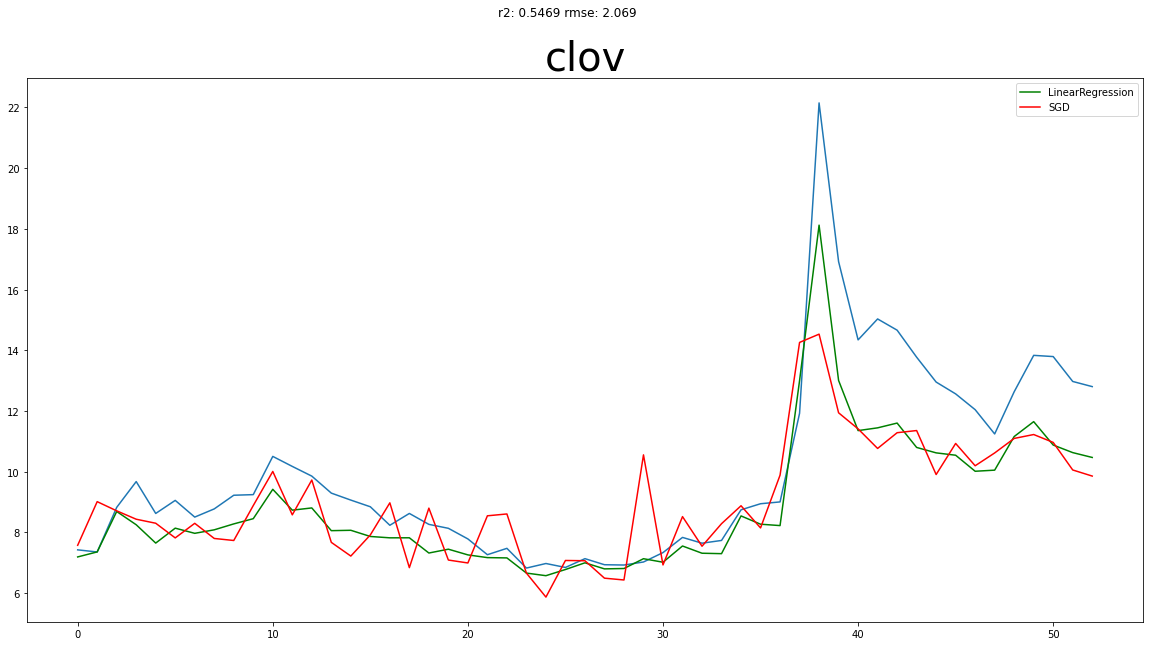

In [4]:
def load_pickle(filepath):
    import pickle
    infile = open(filepath,'rb')
    
    output = pickle.load(infile)
    
    infile.close
    
    return(output)
    


process_tfidf = False

print(symbols)
#//*** Convert symbols to lower case
symbols = [x.lower() for x in symbols]

for symbol in symbols:
    
    #//*** Load Stocks for modeling
    model_df = pd.read_csv(f'./ignore_folder/model_ready_{symbol}_{interval}.csv.zip')
    model_df['time'] = pd.to_datetime(model_df['time'])

    
    #//*** Load tfidf from File
    tfidf = load_pickle(f'./ignore_folder/model_ready_{symbol}_{interval}_tfidf_.pkl')
    
    #//*** Load tfidf matrix into DataFrame
    start_time = time.time()
    print("Building tfidf dataframe")
    tfidf_df = pd.DataFrame(load_pickle(f'./ignore_folder/model_ready_{symbol}_{interval}_tfidf_matrix.pkl').toarray())
    tfidf_df.columns = tfidf.vocabulary_
    
    print("Build tfidf Descending Values")
    descending_vals = list(tfidf_df.sum().sort_values(ascending=False).index)
    
    print("Building TSVD")
    tsvd = TruncatedSVD(5)
    tsvd_df = pd.DataFrame(tsvd.fit_transform(tfidf_df[descending_vals[:1000]]))

    tfidf_df[descending_vals[:1000]]

    train_stock_cols = ['close','volume','open','high','low']
    train_stock_cols = ['score','comment_count','close','volume','open','high','low']
    #train_stock_cols = ['close']
    model_df.reset_index(drop=True,inplace=True)

    #//*** Combine the model columns for training with the tfidf columns
    #X = np.array(pd.concat([model_df[train_stock_cols],tfidf_df[descending_vals[:100]]],ignore_index=True,axis=1))
    X = np.array(pd.concat([model_df[train_stock_cols],tsvd_df],ignore_index=True,axis=1))
    X = np.array(pd.concat([tsvd_df,model_df[train_stock_cols]],ignore_index=True,axis=1))
    #X = tsvd_df
    y = model_df[target_col]
    
    #Convert to 1d Vector
    #X = np.reshape(X, (len(X), 1))
    #y = np.reshape(y, (len(y), 1))
    

    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)

    
    #//*** Scaling 
    scaler = MinMaxScaler()
    
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)

    # Create linear regression object
    #regr = linear_model.LinearRegression()

    # Train the model using the training sets
    #regr.fit(x_train, y_train)
    #result = regr.predict(x_test)
    
    #svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
    #svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
    #scores = cross_val_score(svr_rbf, x_test,y_test,cv=10)

    #svr_rbf.fit(x_test, y_test)
    
    sgd_regr = SGDRegressor( loss="huber", penalty='l1', alpha=0.0001,learning_rate='adaptive')
    
    sgd_regr.fit(x_train,y_train)
    result = sgd_regr.predict(x_test)

    mse = mean_squared_error(y_test, result)
    r2 = r2_score(y_test,result)

    #//*** Root Mean squared Error
    rmse = sqrt(mse)
    
    #//*** Add Results to the predict_df
    results_df.loc[len(results_df)] = [symbol,'target_1','SGD_Regression','tfidf_comments_with_symbol',rmse,r2,y_test,result]

    stock_only_X = model_df[train_stock_cols]
    
    #x_train, x_test, y_train, y_test = train_test_split(stock_only_X,y,test_size=0.2, shuffle=False)

    # Create linear regression object
    regr = linear_model.LinearRegression()
    
    regr.fit(x_train,y_train)

    # Train the model using the training sets
    linear_result = regr.predict(x_test)

    #stock_only_result_rmse = mean_squared_error(y_test, stock_only_result)
    #stock_only_result_r2 = r2_score(y_test,stock_only_result)

    #//*** Add Results to the predict_df
    #results_df.loc[len(results_df)] = [symbol,'target_1','LinearRegression','stock_only',stock_only_result_rmse,stock_only_result_r2,y_test,stock_only_result]


    fig,ax = plt.subplots()

    fig.set_figheight(10)
    fig.set_figwidth(20)
    plot_x = np.arange(len(y_test))
    ax.plot(plot_x,y_test )
    ax.plot(plot_x,linear_result,color='green',label='LinearRegression' )
    ax.plot(plot_x,result,color='red',label='SGD' )
    #ax.scatter(predict_df['time'],predict_df['predict'],color='red' )
    plt.legend()
    plt.title(symbol,fontsize=40)
    plt.suptitle(f"r2: {round(r2,4)} rmse: {round(rmse,4)}")
    plt.show()
    
    break
    

#results_df.to_pickle("./results/results_all_stocks_LinearRegression_Daily_v3.csv.pkl")

Building tfidf dataframe
Build tfidf Descending Values


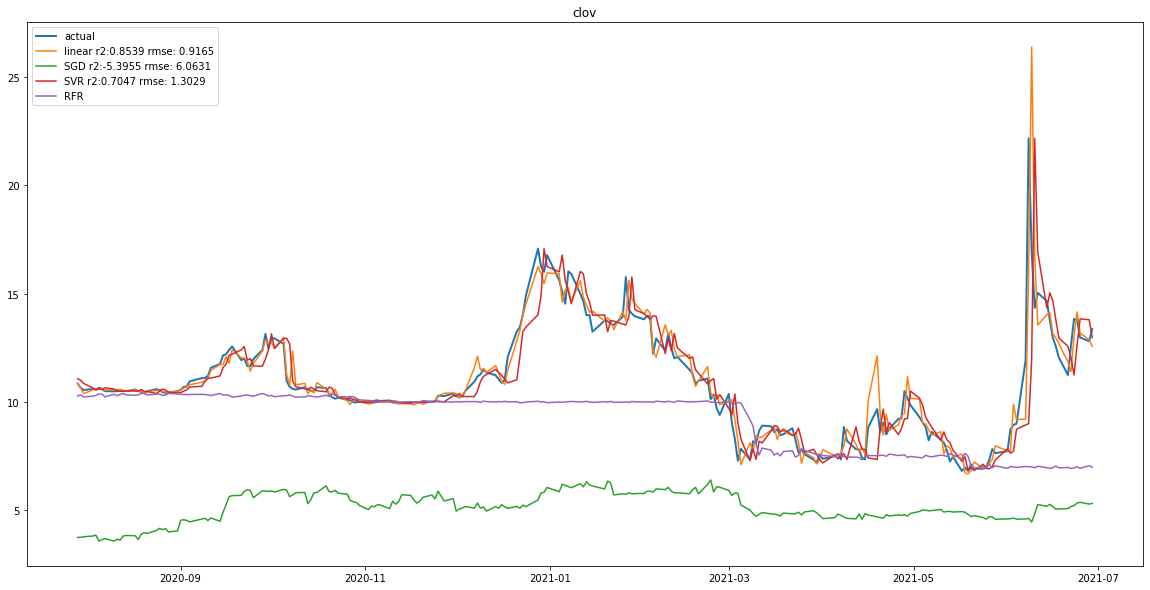

Building tfidf dataframe
Build tfidf Descending Values


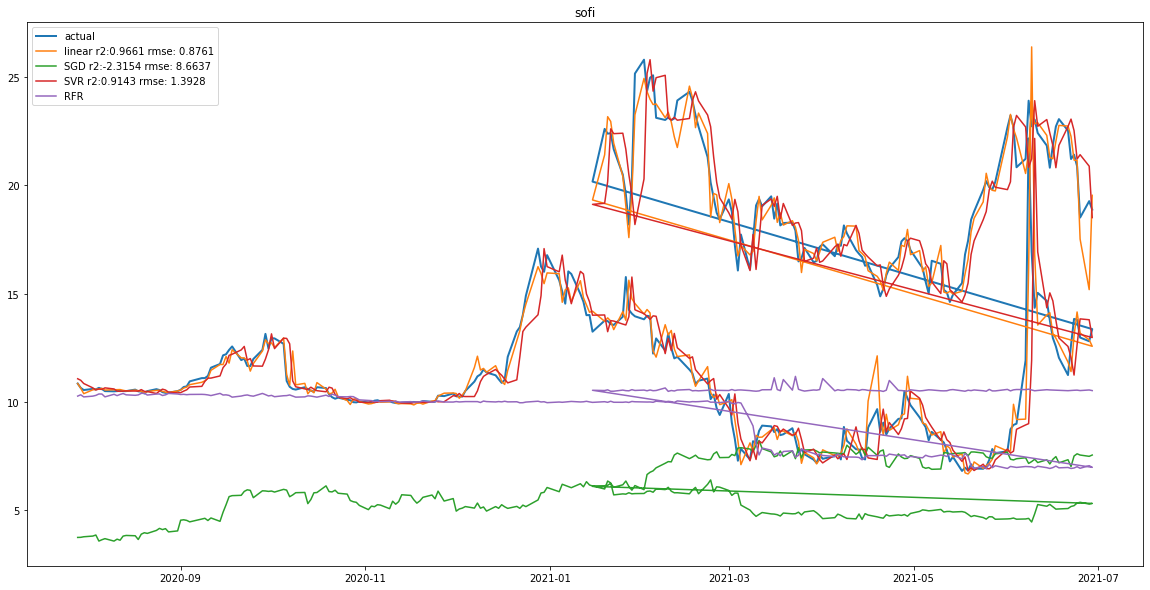

Building tfidf dataframe
Build tfidf Descending Values


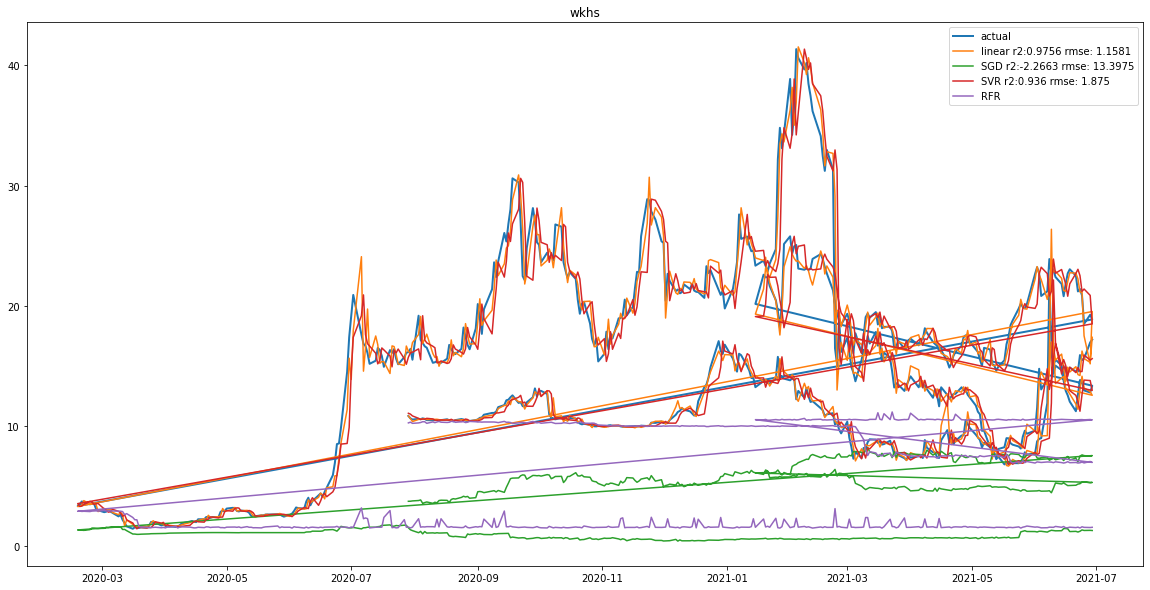

Building tfidf dataframe
Build tfidf Descending Values


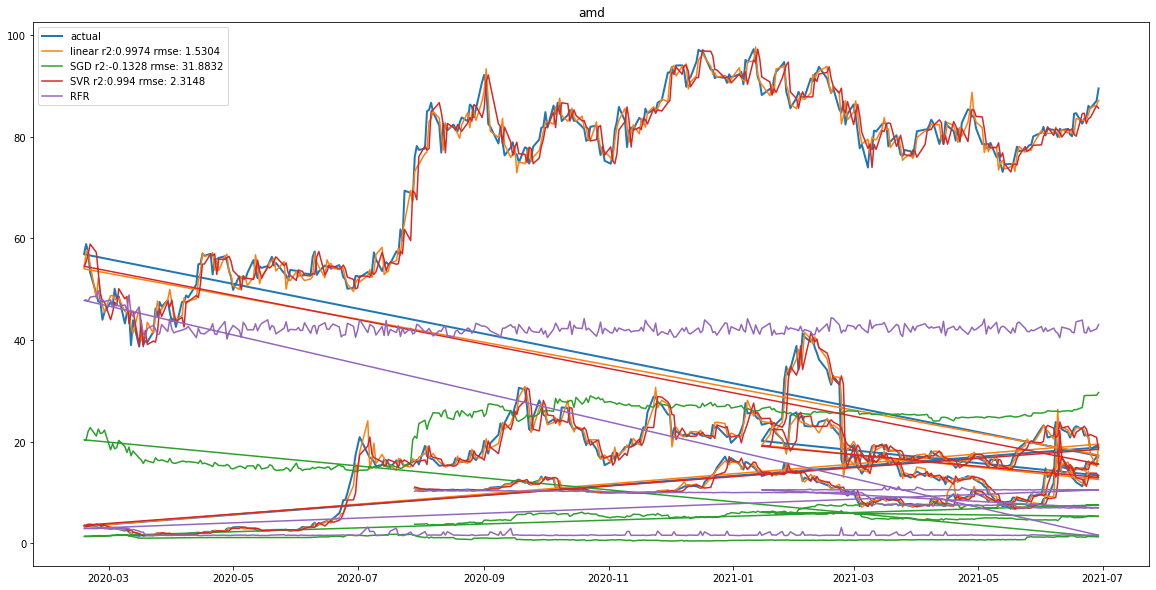

Building tfidf dataframe
Build tfidf Descending Values


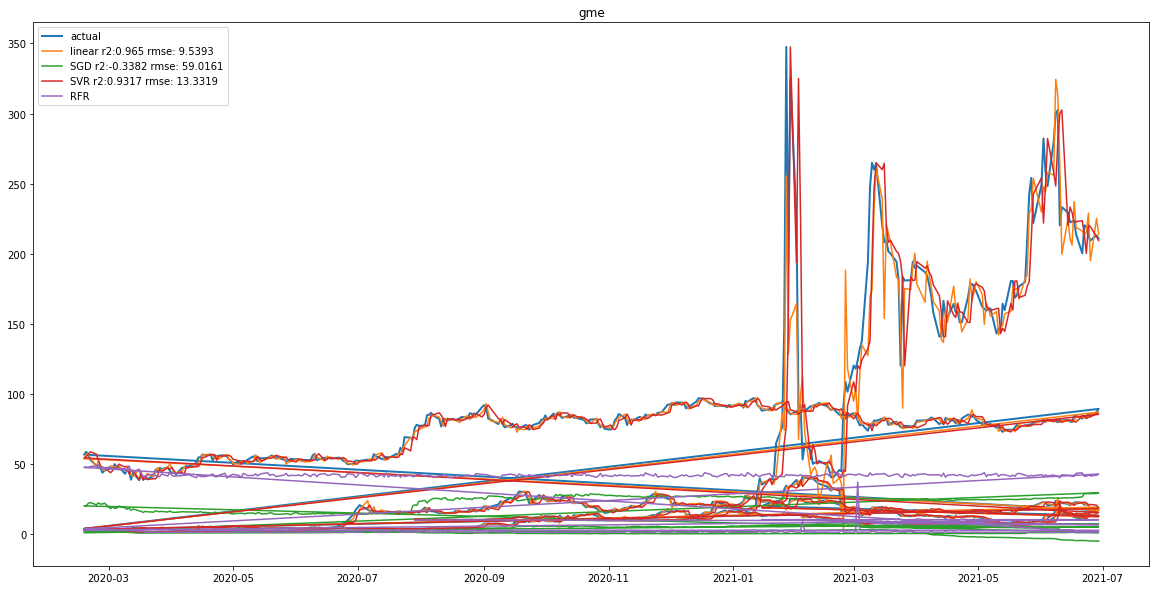

Building tfidf dataframe
Build tfidf Descending Values


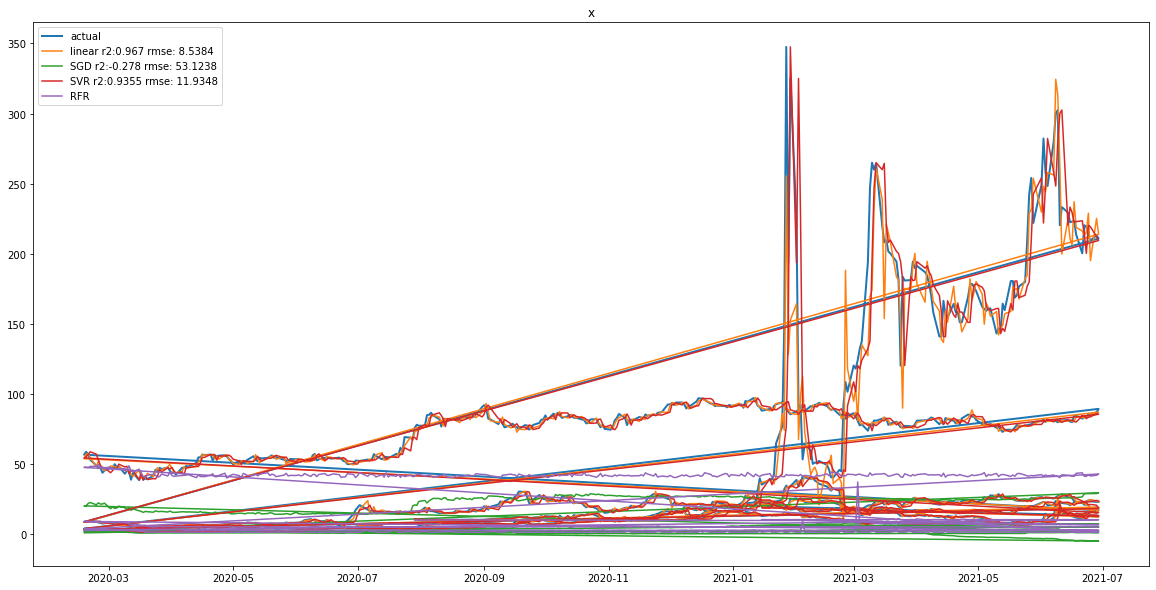

Building tfidf dataframe
Build tfidf Descending Values


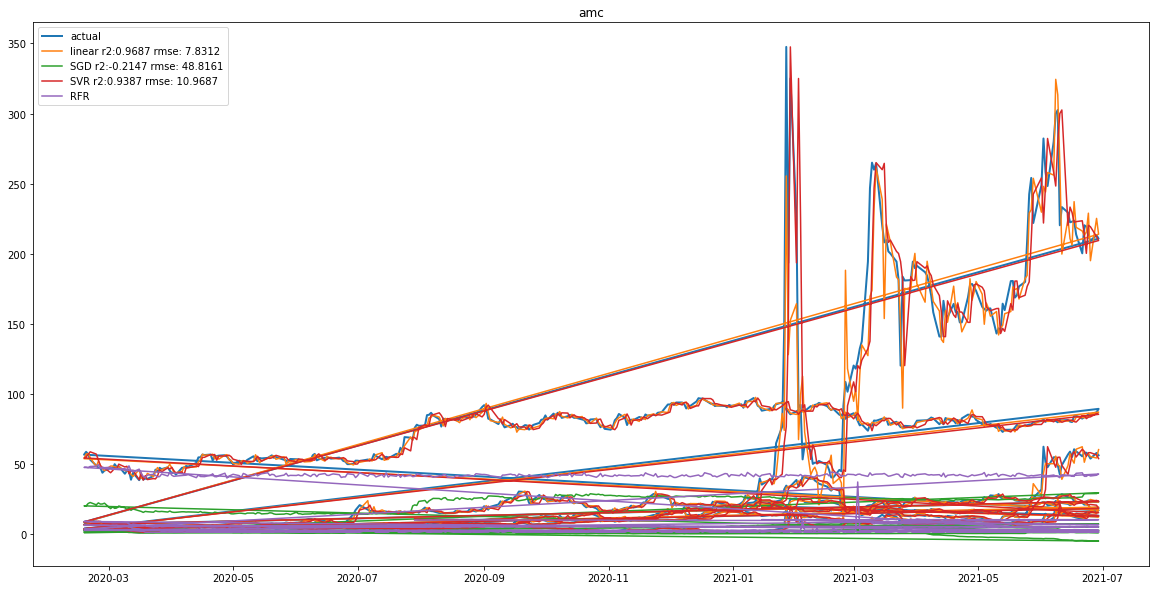

Building tfidf dataframe
Build tfidf Descending Values


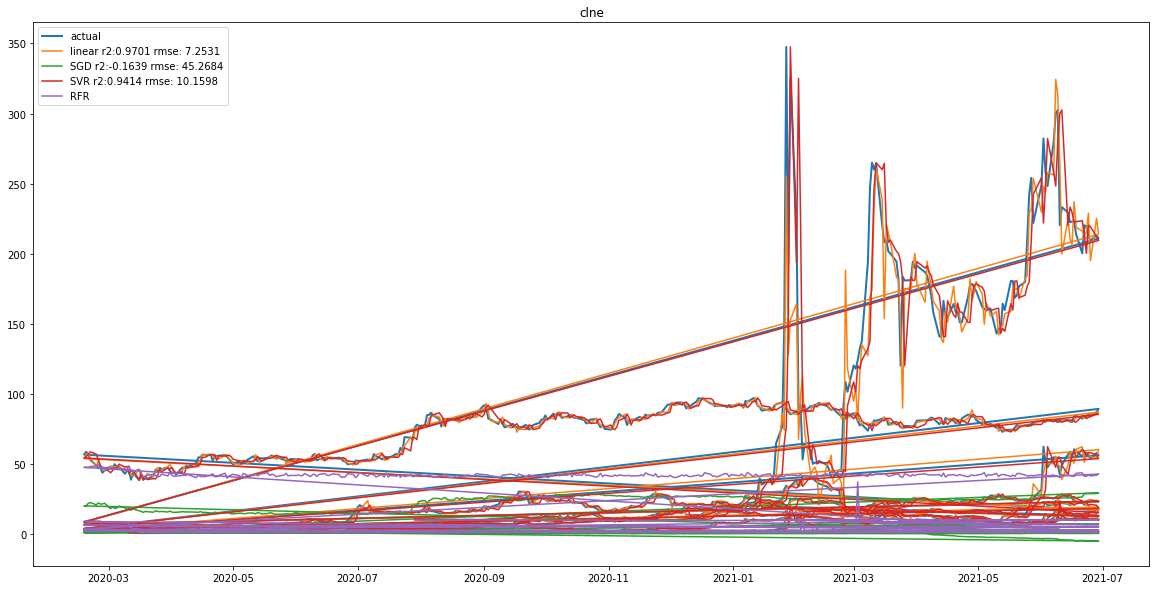

Building tfidf dataframe
Build tfidf Descending Values


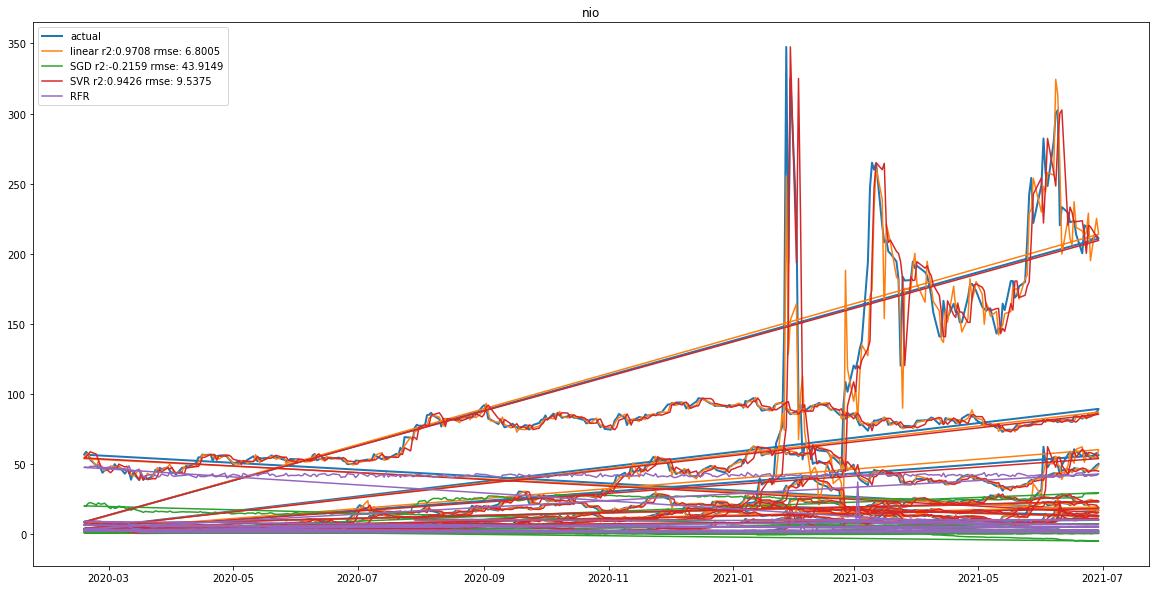

Building tfidf dataframe
Build tfidf Descending Values


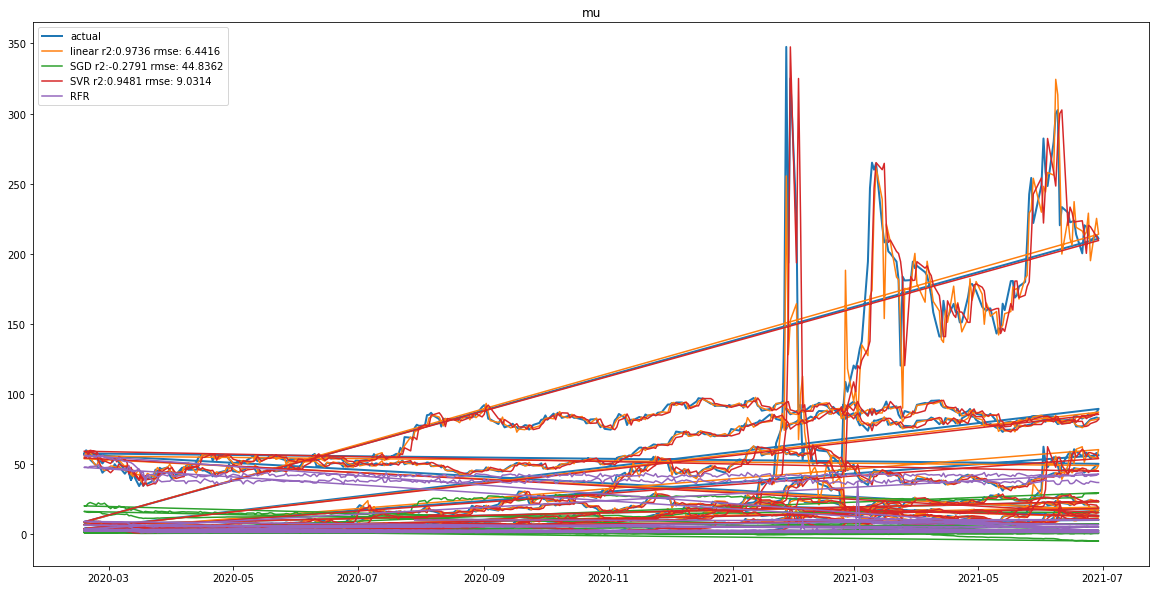

Building tfidf dataframe
Build tfidf Descending Values


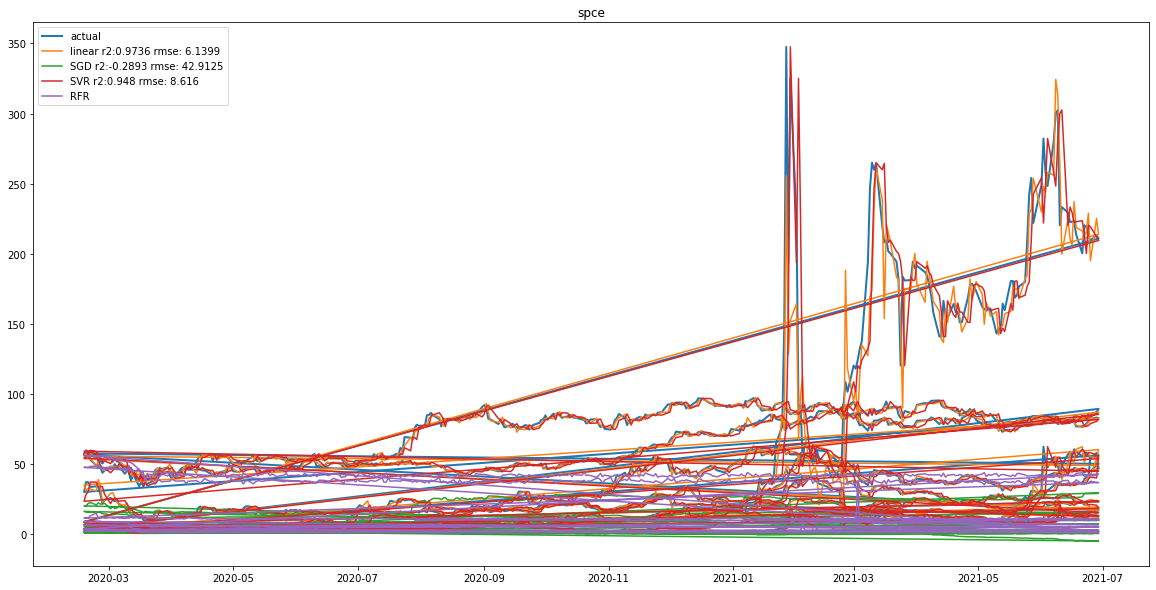

Building tfidf dataframe
Build tfidf Descending Values


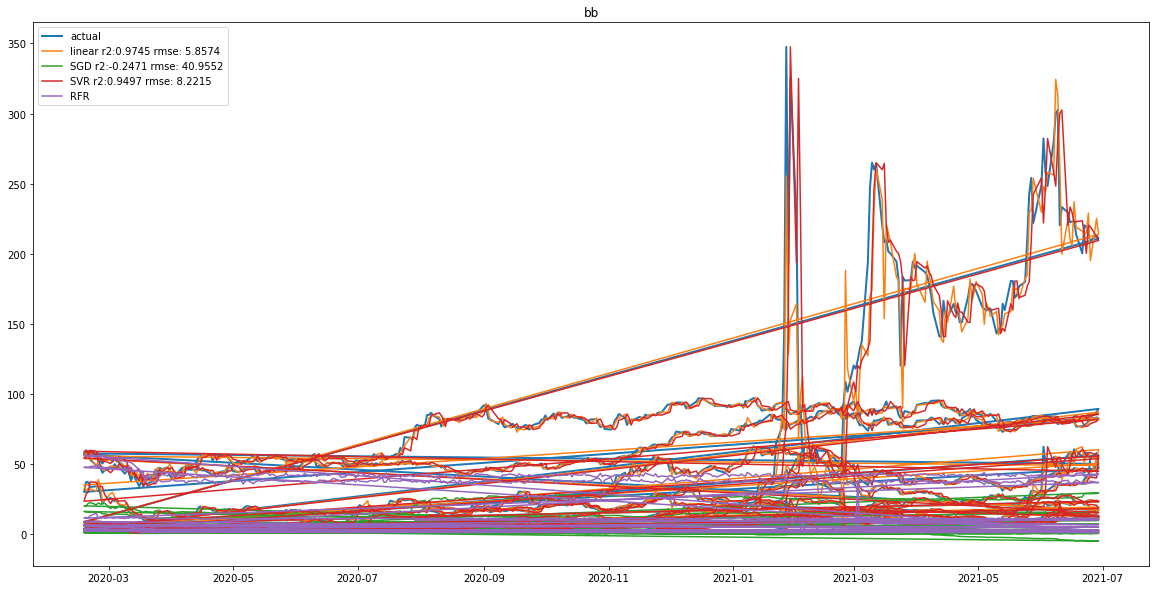

done


In [32]:
#//*** Blind Ensemble Modeling. Starts at 30 days and models Day 31. Models 31 days, to Model Day 32, Models 32 days to Model Day 33

training_days = 30
train_start_slice = 0
train_end_slice = training_days

predict_col = [f'target_1']

tfidf_top_cols = 500

predict_df = pd.DataFrame(columns=['symbol','time','actual','linear','sgd','svr','rfr'])


for symbol in symbols:
    
    #//*** Load Stocks for modeling
    model_df = pd.read_csv(f'./ignore_folder/model_ready_{symbol}_{interval}.csv.zip')
    model_df['time'] = pd.to_datetime(model_df['time'])

    
    #//*** Load tfidf from File
    tfidf = load_pickle(f'./ignore_folder/model_ready_{symbol}_{interval}_tfidf_.pkl')
    
    #//*** Load tfidf matrix into DataFrame
    start_time = time.time()
    print("Building tfidf dataframe")
    tfidf_df = pd.DataFrame(load_pickle(f'./ignore_folder/model_ready_{symbol}_{interval}_tfidf_matrix.pkl').toarray())
    tfidf_df.columns = tfidf.vocabulary_
    
    print("Build tfidf Descending Values")
    descending_vals = list(tfidf_df.sum().sort_values(ascending=False).index)
    

    
    tfidf_df[descending_vals[:1000]]
    train_stock_cols = ['close','volume','open','high','low']
    train_stock_cols = ['score','comment_count','close','volume','open','high','low']
    #train_stock_cols = ['close']
    model_df.reset_index(drop=True,inplace=True)


    #//*** Lengthy K-Means Run. Runs a model on every day after 60+ and predicts the next day. Uses the previous 60 days to predict the next day. 
    #//*** It may or may not be helpful to run k-means across the whole tfidf instead of the previous 60.


    

    #//*** Loop through model_df. Model each day individually. Train 60 days, Predict 61.
    
    #Loop through combined 
    for row_int in range(0,len(model_df)-training_days-1):


        #//*** Build the slice start index
        start_dex = train_start_slice+row_int
        start_dex = 0
        #//*** Build the slice end index
        end_dex = train_end_slice+row_int

        dc = f"{start_dex}/{len(model_df)}"
        
        #//*** Build the sliced training df
        train_df = model_df[start_dex:end_dex].copy()
        train_df.reset_index(inplace=True,drop=True) 
        
        #print("Building TSVD")
        tsvd = TruncatedSVD(5)
        tsvd_df = tfidf_df[start_dex:end_dex].copy()
        
        
        
        descending_vals = list(tfidf_df.sum().sort_values(ascending=False).index)
        
        tsvd_df = tsvd_df[descending_vals][:tfidf_top_cols]
        
        if tsvd_df.sum().sum() == 0:
            tsvd_df = pd.DataFrame()
        else:
            tsvd_df = pd.DataFrame(tsvd.fit_transform(tsvd_df))
        
        
        

        #//*** Build the row index on the prediction (train_end_slice+1)
        predict_dex = row_int+train_end_slice+1

        #print("Starting K-Means...")
        offset=1
        

        
        
        #print(train_df[train_stock_cols].head(5))

        #x_train = np.array(train_df[train_stock_cols])
        #print(pd.concat([tsvd_df,train_df[train_stock_cols]],ignore_index=True,axis=1).head(5))
        
        x_train = np.array(pd.concat([tsvd_df,train_df[train_stock_cols]],ignore_index=True,axis=1))
        
        
        #print(x_train[:5])
        y_train = np.array(train_df[predict_col].values.ravel())

        #//*** Grabs a single item from the Datframe, which returns a series.
        #//*** Transpose() gets it into the proper 2-D format
        x_test = pd.DataFrame(model_df.iloc[end_dex+1].copy()).transpose()
        
        #//*** Combine the last tsvd_df value, and the next day's stock_df values to test for prediction
        #//*** The gets needlessly complicated since these are 1-d arrays
        if len(tsvd_df) > 0:
            x_test = np.array(list(tsvd_df.iloc[-1]) + list(np.array(x_test[train_stock_cols])[0])).reshape(1, -1)
        else:
            x_test = np.array(x_test[train_stock_cols])[0].reshape(1, -1)
        
        #//*** Scaling 
        scaler = MinMaxScaler()
        
        x_train_linear = x_train
        x_test_linear = x_test
    
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)

        y_test = np.array(model_df[predict_col].iloc[end_dex:end_dex+1],)[0]
        

        random_forest = RandomForestRegressor(n_estimators=10,n_jobs=-1) 
        random_forest.fit(x_train,y_train)
        rf_result = random_forest.predict(x_test.reshape(1, -1))

        
        svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
        svr_rbf = SVR(kernel= 'rbf', C= .001, gamma= 0.1)
        
        svr_rbf.fit(x_test, y_test)
        svr_result = svr_rbf.predict(x_test)

        #sgd_regr = SGDRegressor( loss="huber", penalty='elasticnet', alpha=0.0001,learning_rate='adaptive')
        sgd_regr = SGDRegressor( loss="huber", penalty='l1', alpha=0.0001,max_iter=10000,learning_rate='adaptive')
            
        sgd_regr.fit(x_train,y_train)
        sgd_result = sgd_regr.predict(x_test.reshape(1, -1))

        # Create linear regression object
        linear_regr = linear_model.LinearRegression()

        # Train the model using the training sets
        linear_regr.fit(x_train_linear, y_train)
        linear_result = linear_regr.predict(x_test_linear)




        #//*** Add Results to the predict_df
        predict_df.loc[len(predict_df)] = [symbol,model_df.iloc[predict_dex]['time'],model_df.iloc[predict_dex]['close'],linear_result[0],sgd_result[0],svr_result[0],rf_result[0]]

    #print("Done!")
    predict_df




    linear_r2 = round(r2_score(predict_df['actual'],predict_df['linear']),4)
    linear_rmse = round(sqrt(mean_squared_error(predict_df['actual'], predict_df['linear'])),4)

    sgd_r2 = round(r2_score(predict_df['actual'],predict_df['sgd']),4)
    sgd_rmse = round(sqrt(mean_squared_error(predict_df['actual'], predict_df['sgd'])),4)

    svr_r2 = round(r2_score(predict_df['actual'],predict_df['svr']),4)
    svr_rmse = round(sqrt(mean_squared_error(predict_df['actual'], predict_df['svr'])),4)


    fig,ax = plt.subplots()

    fig.set_figheight(10)
    fig.set_figwidth(20)
    plot_x = np.arange(len(y_test))
    plot_df = predict_df[predict_df['symbol'] == symbol]
    ax.plot(plot_df['time'],plot_df['actual'],label='actual',linewidth=2 )
    ax.plot(plot_df['time'],plot_df['linear'],label=f"linear r2:{linear_r2} rmse: {linear_rmse}" )
    ax.plot(plot_df['time'],plot_df['sgd'],label=f"SGD r2:{sgd_r2} rmse: {sgd_rmse}" )
    ax.plot(plot_df['time'],plot_df['svr'],label=f"SVR r2:{svr_r2} rmse: {svr_rmse}" )
    ax.plot(plot_df['time'],plot_df['rfr'],label=f"RFR" )



    plt.title(f"{symbol}")
    #plt.title(f"SGD r2: {round(sgd_r2,4)} -- rmse: {round(sgd_rmse,4)}")
    plt.legend()
    plt.show()



        #print(rmse)
        #print(result)

        #//*** Update Results_df
        #results_df.loc[len(results_df)] = [predict_col[0],rmse,r2,min_slice,mid_slice,max_slice,np.array(y_test),result]
predict_df.to_pickle("./results/results_ensemble_Daily_v1.csv.pkl")
print('done')

In [26]:
predict_df.to_pickle("./results/results_ensemble_Daily_v1.csv.pkl")

In [ ]:
#//***Keras Linear Regression...Not getting very far

def load_pickle(filepath):
    import pickle
    infile = open(filepath,'rb')
    
    output = pickle.load(infile)
    
    infile.close
    
    return(output)

def model_regr(dim_size,lrn_rate = 0.01, mntum = 0 ):
    #Intializing the RNN
    model = Sequential()
    #1st layer
    size=1000
    model.add(layers.Dense(dim_size, activation='relu', input_shape=(dim_size,)))
    #network.add(layers.Dense(32, activation='relu'))
    #network.add(layers.Dense(1))
    #model.add(Dropout(0.2))
    #2nd layer
#    model.add(layers.Dense(size/4, activation='relu'))
#    model.add(layers.Dense(size/8, activation='relu'))
#    model.add(layers.Dense(size/16, activation='relu'))

    
    #model.add(Dropout(0.2))
    #Adding the output layer
    model.add(layers.Dense(1))
    #model.compile(loss = 'mse', optimizer='adam', metrics=['mse','mae','mape'])
    #model.compile(loss = 'mse', optimizer='RMSprop', metrics=['mse','mae','mape'])
    model.compile(loss = 'mae', optimizer='adam', metrics=['mse','mae','mape'])
    return model

#//*** Input_filename: Comments to Process.
#//*** This will eventually be a list of files
#input_filename  =".\\data\\wallstreetbets_comments.csv.zip"
interval="daily"
target_col = 'target_1'
#//*** Path to the stock ticker JSON file
stock_ticker_filename = "./data/stock_tickers.json"


results_df = pd.DataFrame(columns=['symbol','target','model','data','rmse','r2','actual','predict'])

#//*** Load the Stock Tickers
f = open(stock_ticker_filename, "r")
symbols = json.loads(f.read())['symbols']

#symbols = ["bb"]
f.close()

process_tfidf = False

print(symbols)
#//*** Convert symbols to lower case
symbols = [x.lower() for x in symbols]

for symbol in symbols:
    
    #//*** Load Stocks for modeling
    model_df = pd.read_csv(f'./ignore_folder/model_ready_{symbol}_{interval}.csv.zip')
    model_df['time'] = pd.to_datetime(model_df['time'])

    
    #//*** Load tfidf from File
    tfidf = load_pickle(f'./ignore_folder/model_ready_{symbol}_{interval}_tfidf_.pkl')
    
    #//*** Load tfidf matrix into DataFrame
    start_time = time.time()
    print("Building tfidf dataframe")
    tfidf_df = pd.DataFrame(load_pickle(f'./ignore_folder/model_ready_{symbol}_{interval}_tfidf_matrix.pkl').toarray())
    tfidf_df.columns = tfidf.vocabulary_
    
    print("Build tfidf Descending Values")
    descending_vals = list(tfidf_df.sum().sort_values(ascending=False).index)
    
    print("Building TSVD")
    tsvd = TruncatedSVD(5)
    tsvd_df = pd.DataFrame(tsvd.fit_transform(tfidf_df[descending_vals[:200]]))

    #tfidf_df[descending_vals[:1000]]

    train_stock_cols = ['close','volume','open','high','low']
    train_stock_cols = ['score','comment_count','close','volume','open','high','low']
    #train_stock_cols = ['close','open','high','low']
    #train_stock_cols = ['close']
    model_df.reset_index(drop=True,inplace=True)

    #//*** Combine the model columns for training with the tfidf columns
    #X = np.array(pd.concat([model_df[train_stock_cols],tfidf_df[descending_vals][:10]],ignore_index=True,axis=1))
    X = np.array(pd.concat([model_df[train_stock_cols],tsvd_df],ignore_index=True,axis=1))
    #X = np.array(pd.concat([tsvd_df,model_df[train_stock_cols]],ignore_index=True,axis=1))
    #X = tsvd_df
    y = model_df[target_col]
    
    scaler = MinMaxScaler()
    #X = scaler.fit_transform(X)
    
    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)
    
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
            
        

    regr = model_regr(x_train.shape[1],lrn_rate=0.01, mntum=0)
    history = regr.fit(x_train, y_train, batch_size=1, verbose=1, epochs=10)
    print(f"Run time internal GPU: {time.time()-start_time}")
    result = regr.predict(x_test)
    
    mse = mean_squared_error(y_test, result)
    r2 = r2_score(y_test,result)

    #//*** Root Mean squared Error
    rmse = sqrt(mse)

    print(history.history.keys())

    fig,ax = plt.subplots()
    
    for x in history.history.keys():
        
        plt.plot(history.history[x],label=x)
    
    plt.legend()
    plt.show()
    #//*** Add Results to the predict_df
#    results_df.loc[len(results_df)] = [symbol,'target_1','LinearRegression','tfidf_comments_with_symbol',rmse,r2,y_test,result]


    #//*** Add Results to the predict_df
    #results_df.loc[len(results_df)] = [symbol,'target_1','LinearRegression','stock_only',stock_only_result_rmse,stock_only_result_r2,y_test,stock_only_result]


    fig,ax = plt.subplots()

    fig.set_figheight(10)
    fig.set_figwidth(20)
    plot_x = np.arange(len(y_test))
    ax.plot(plot_x,y_test )
    #ax.plot(plot_x,stock_only_result,color='green',label='Stock Only Regression' )
    ax.scatter(plot_x,result,color='red',label='With TFIDF' )
    #ax.scatter(predict_df['time'],predict_df['predict'],color='red' )
    plt.legend()
    plt.title(symbol,fontsize=40)
    plt.suptitle(f"r2: {round(r2,4)} rmse: {round(rmse,4)}")
    plt.show()
    
    break
    

results_df.to_pickle("./results/results_all_stocks_Keras_Regression_Daily_v2.csv.pkl")

In [ ]:
model_df

# OLD CODE to CLEAN UP BELOW

In [ ]:
fig,ax = plt.subplots()

ax.plot(model_df['time'],model_df['comment_count'] )



    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

fig,ax = plt.subplots()

ax.plot(model_df['time'],model_df['comment_count'] )



    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()



In [ ]:
results_df = pd.DataFrame(columns=['target','rmse','r2','start','mid','end','actual','predict'])

In [ ]:
predict_df = pd.DataFrame(columns=['time','actual','predict'])

In [ ]:
#//*** Lengthy K-Means Run. Runs a model on every day after 60+ and predicts the next day. Uses the previous 60 days to predict the next day. 
#//*** It may or may not be helpful to run k-means across the whole tfidf instead of the previous 60.

predict_df = pd.DataFrame(columns=['time','actual','predict','best_r'])

#//*** Loop through model_df. Model each day individually. Train 60 days, Predict 61.
training_days = 60
train_start_slice = 0
train_end_slice = training_days
cluster_iterations = 50
predict_col = [f'target_1']
train_cols = ['cluster_1','close','volume','open','high','low']
#Loop through combined 
for row_int in range(0,len(tdf)-training_days-1):
    
    
    #//*** Build the slice start index
    start_dex = train_start_slice+row_int
    
    #//*** Build the slice end index
    end_dex = train_end_slice+row_int
    
    dc = f"{start_dex}/{len(model_df)}"

    #//*** Build the sliced training df
    train_df = model_df[start_dex:end_dex].copy()

    tfidf = TfidfVectorizer()

    #print(dc, " Starting tfidf....")
    start_time = time.time()
    tfidf = TfidfVectorizer()
    train_tfidf = tfidf.fit_transform(train_df['body'])
    print(dc,f"tfidf Built: {round(time.time()-start_time,2)}s")
    
    
    #//*** Build the row index on the prediction (train_end_slice+1)
    predict_dex = row_int+train_end_slice+1
    
    #print("Starting K-Means...")
    offset=1
    best_r = 0
    best_cluster = []
    for x in range(1,cluster_iterations):

        start_time=time.time()
        kmeans = KMeans(n_clusters=5,init='random').fit(train_tfidf)
        cluster = kmeans.predict(train_tfidf)
        r,p = pearsonr(train_df[f'target_{offset}'],cluster)
        r = abs(r)
        #print(r,round(p,6))

        if p < .05:
            if r > best_r:
                best_r = r
                best_cluster = cluster
            #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
        if x == 1:
            print(dc,f"Estimated Cluster Run Time: {round( (time.time()-start_time)*cluster_iterations-1,2) }s")
    #print(f"Best R:{best_r}")
     
    train_df[f'cluster_{offset}'] = best_cluster

    
    x_train = np.array(train_df[train_cols])
    y_train = np.array(train_df[predict_col])

    x_test = pd.DataFrame(model_df.iloc[end_dex+1].copy()).transpose()
    
    x_test[f'cluster_{offset}'] = best_cluster[0]
    x_test = np.array(x_test[train_cols])
    

    y_test = model_df[predict_col].iloc[end_dex:end_dex+1]

    #regr_iter = 20

    start_time = time.time()

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(x_train, y_train)
    result = regr.predict(x_test)



    print(dc,f"[{result[0][0]}]  Actual: {model_df.iloc[predict_dex]['close']} - Best R2: {best_r}")
    
    
    #//*** Add Results to the predict_df
    predict_df.loc[len(predict_df)] = [model_df.iloc[predict_dex]['time'],model_df.iloc[predict_dex]['close'],result[0][0],best_r]

print("Done!")
predict_df

In [ ]:
predict_df.to_csv("./results/amc_daily_60_to_1_model.csv",index=False)

In [ ]:
predict_df
fig,ax = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(y_test))
ax.plot(predict_df['time'],predict_df['actual'] )
ax.scatter(predict_df['time'],predict_df['predict'],color='red' )
plt.suptitle(f"AMC Model Train 60: Predict 1")
plt.show()

In [ ]:
x_test = (model_df.iloc[end_dex+1].copy())
x_test = pd.DataFrame(model_df.iloc[end_dex+1].copy()).transpose()
x_test[f'cluster_{offset}'] = best_cluster[0]
#x_test = x_test.append( pd.Series(best_cluster[0], index = [f'cluster_{offset}']) )
x_test
x_train
x_train = np.array(train_df[train_cols].iloc[start_dex:end_dex])
y_train = np.array(train_df.iloc[start_dex:end_dex][predict_col],)
train_df


In [ ]:
#//*** Train 60
#//*** Model 30
#//*** The Original K-Means Model


#//*** Divide up the data in 60 day intervals to predict the next 30 days
days = 30 
train_cols = ['cluster_1','close','volume','open','high','low']
cluster_iterations = 50


for index in range(2,int(len(tdf)/days)):
    
    min_slice = ((index-2)*days)
    mid_slice = index*days
    max_slice = (index*days)+days
    print(index,"Train Range:",min_slice,mid_slice," - Test Range:", mid_slice, max_slice  )
    
    train_df = tdf[min_slice:max_slice].copy()

    tfidf = TfidfVectorizer()

    print("Starting tfidf....")
    start_time = time.time()
    tfidf = TfidfVectorizer()
    train_tfidf = tfidf.fit_transform(train_df['body'])
    print(f"Built: {round(time.time()-start_time,2)}")
    
    print("Starting K-Means...")
    offset=1
    best_r = 0
    best_cluster = []
    for x in range(1,cluster_iterations):

        start_time=time.time()
        kmeans = KMeans(n_clusters=5,init='random').fit(train_tfidf)
        cluster = kmeans.predict(train_tfidf)
        r,p = pearsonr(train_df[f'target_{offset}'],cluster)
        r = abs(r)
        #print(r,round(p,6))

        if p < .05:
            if r > best_r:
                best_r = r
                best_cluster = cluster
            #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
        if x == 1:
            print(f"Estimated Cluster Run Time: {round( (time.time()-start_time)*cluster_iterations-1,2) }s")
    print(f"Best R:{best_r}")
    train_df[f'cluster_{offset}'] = best_cluster
    
     
    for tgt in [1,2,3,4,5,6,7,8,9,10]:
        predict_col = [f'target_{tgt}']
        x_train = np.array(train_df[train_cols].iloc[0:days*2*-1])
        y_train = np.array(train_df.iloc[0:days*2*-1][predict_col],)

        x_test = train_df[train_cols].iloc[days*2*-1:]
        y_test = train_df[predict_col].iloc[days*2*-1:]

        regr_iter = 20

        start_time = time.time()

        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(x_train, y_train)
        result = regr.predict(x_test)

        mse = mean_squared_error(y_test, result)
        r2 = r2_score(y_test,result)
        
        #//*** Root Mean squared Error
        rmse = sqrt(mse)

        # Plot outputs
        display_size = 40

        fig,ax = plt.subplots()
        plot_x = np.arange(len(y_test))
        ax.plot(plot_x,y_test )
        ax.scatter(plot_x,result,color='red' )
        plt.suptitle(f"{predict_col}\nRmse: {rmse} - r2 {r2}")
        plt.show()
        
        

        #print(rmse)
        #print(result)

        #//*** Update Results_df
        results_df.loc[len(results_df)] = [predict_col[0],rmse,r2,min_slice,mid_slice,max_slice,np.array(y_test),result]
print('done')

In [ ]:
results_df

In [ ]:
#results_df.to_pickle("./results_amc_daily_kmeans_ols.pkl")


In [ ]:
print(model_df)
tfidf = TfidfVectorizer()
whole_tfidf = tfidf.fit_transform(model_df['body'])
whole_tfidf

In [ ]:
t = whole_tfidf.toarray()


In [ ]:
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(t[0]))
for x in t:
    ax.scatter(plot_x,x,s=1 )
plt.show()

In [ ]:
vocab_df = pd.DataFrame()
vocab_df['word'] = tfidf.vocabulary_
vocab_df['score'] = tfidf.idf_

In [ ]:
tfidf_df = pd.DataFrame(whole_tfidf.toarray())
tfidf_df.columns = tfidf.vocabulary_

#tfidf_df[tfidf_df.columns[:10]]


list(vocab_df.sort_values('score',ascending=True)['word'])
#tfidf_df.columns = (range(len(tfidf_df.columns)))
tfidf_df[tfidf_df.columns[:10]]

In [ ]:
vocab_df = pd.DataFrame()
vocab_df['word'] = tfidf.vocabulary_
vocab_df['score'] = tfidf.idf_
tfidf_df = pd.DataFrame(whole_tfidf.toarray())
ascending_vals = list(tfidf_df.sum().sort_values(ascending=True).index)
descending_vals = list(tfidf_df.sum().sort_values(ascending=False).index)
vocab_vals = list(vocab_df.sort_values('score',ascending=True)['word'])

In [ ]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(3)
tsvd_df = pd.DataFrame(tsvd.fit_transform(tfidf_df[descending_vals[:100]]))
print(tsvd.explained_variance_ratio_.sum())
tsvd_df**2

In [ ]:

x_test = pd.DataFrame(model_df.iloc[end_dex+1].copy()).transpose()

x_test[f'cluster_{offset}'] = best_cluster[0]
x_test = np.array(x_test[train_cols])





y_test = model_df[predict_col].iloc[end_dex:end_dex+1]

#regr_iter = 20

start_time = time.time()




In [ ]:
plot_df = tfidf_df[descending_vals]
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(plot_df.columns))
for x in range(len(plot_df)):
    ax.scatter(plot_x,plot_df.iloc[x],s=1 )
plt.show()


fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(plot_df.columns[:1000]))
for x in range(len(plot_df)):
    ax.scatter(plot_x,plot_df[plot_df.columns[:1000]].iloc[x],s=1 )
plt.show()

In [ ]:
for x in plot_df[plot_df.columns[:100]]:
    print(x)

In [ ]:
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(plot_df.columns))
ax.scatter(plot_df.index,plot_df[plot_df.columns[0]])
plt.show()

In [ ]:
plot_df = tfidf_df[vocab_vals]
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(plot_df.columns))
for x in range(len(plot_df)):
    ax.scatter(plot_x,plot_df.iloc[x],s=1 )
plt.show()

In [ ]:
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(tfidf_df.columns))

#for x in range(len(tfidf_df)):
ax.scatter(plot_x,tfidf_df.iloc[0][descending_vals],s=5,color='green' )
#tfidf_df.columns = tfidf_df.sum().sort_values(ascending=True).index
ax.scatter(plot_x,tfidf_df.iloc[0][ascending_vals],s=2,color='black' )
plt.show()

In [ ]:
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(100)
fig.set_figwidth(200)
plot_x = np.arange(len(tfidf_df.columns))
for x in range(len(tfidf_df)):
    ax.scatter(plot_x,tfidf_df.iloc[x],s=1 )
plt.show()

In [ ]:
"""

print("Finding best cluster for classification")

train_slice = (270,300)
train_interval = 10

cluster_iterations = 50

train_df = tdf[train_slice[0]:train_slice[1]+train_interval].copy()

tfidf = TfidfVectorizer()

print("Starting tfidf....")
start_time = time.time()
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(train_df['body'])


print(f"Built: {round(time.time()-start_time,2)}")
print("Starting K-Means...")
offset=1
best_r = 0
best_cluster = []
for x in range(1,cluster_iterations):
    
    start_time=time.time()
    kmeans = KMeans(n_clusters=5,init='random').fit(train_tfidf)
    cluster = kmeans.predict(train_tfidf)
    r,p = pearsonr(train_df[f'target_{offset}'],cluster)
    r = abs(r)
    #print(r,round(p,6))
    
    if p < .05:
        if r > best_r:
            best_r = r
            best_cluster = cluster
        #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
    if x == 1:
        print(f"Estimated Cluster Run Time: {round( (time.time()-start_time)*cluster_iterations-1,2) }s")
print(best_r,best_cluster)
train_df[f'cluster_{offset}'] = best_cluster
train_df
   
   """
print()

In [ ]:
 
"""

train_cols = ['cluster_1','close','volume','open','high','low']
predict_col = ['target_1']
x_train = np.array(train_df[train_cols].iloc[0:train_interval*-1])
y_train = np.array(train_df.iloc[0:train_interval*-1][predict_col],)

x_test = train_df[train_cols].iloc[train_interval*-1:]
y_test = train_df[predict_col].iloc[train_interval*-1:]


import time
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

regr_iter = 20

start_time = time.time()

print("Regressing")


#regr = MLPRegressor(max_iter=50000).fit(x_train,y_train)
#scores = cross_val_score(regr, x_train, y_train, cv=5)
print(f"Complete: {round(time.time()-start_time,2)}" )
#//*** Score the model
#score = regr.score(x_train, y_train)
#result = regr.predict(x_test)


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)
result = regr.predict(x_test)
# Plot outputs
display_size = 40

fig,ax = plt.subplots()
plot_x = np.arange(len(y_test))
ax.plot(plot_x,y_test )
ax.scatter(plot_x,result,color='red' )

plt.show()
mse = mean_squared_error(y_test, result)

#//*** Root Mean squared Error
rmse = sqrt(mse)

print(rmse)
print(result)

"""

In [ ]:
#//***Aggreate Comments for Training
#//*** Build tfidf
from sklearn.feature_extraction.text import TfidfVectorizer


#loop_list.append(tfidf.fit_transform(input_df['tfidf']))
tfidf_matrix = []
tfidf_list = []
tfidf = TfidfVectorizer()

print("Starting tfidf....")
start_time = time.time()
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(tdf['body'])


print(f"Built: {round(time.time()-start_time,2)}")

print(tfidf_matrix)
print

In [ ]:
"""
#//*** Build TruncatedSVD

#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import TruncatedSVD

start_time = time.time()
print(f"Begin Truncated SVD ")

start_time=time.time()
#//*** Set the number of components to 6000. This is generating 98% variance capture
#//*** 60min data set took around 25minutes to build
tsvd = TruncatedSVD(250)
tsvd_df = pd.DataFrame(tsvd.fit_transform(tfidf_matrix))
print(tsvd.explained_variance_ratio_.sum())

print (f"Truncated SVD Done: {round(time.time()-start_time,2)}s")
#output_filename = './ignore_folder/tsvd_model_ready_daily.csv.zip'
#//*** Write Truncated SVD to disk
#tsvd_df.to_csv(output_filename, compression='zip', index=False)
"""
print("Truncated SVD Code")

LTSM: https://www.datacamp.com/community/tutorials/lstm-python-stock-market


In [ ]:
import time
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [ ]:
tsvd_df

In [ ]:
fig,ax = plt.subplots()

for col in tsvd_df.columns:

    ax.scatter(tsvd_df[col],tsvd_df.index,label=col )


    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
        curr_center = centroids[pred_clusters[i]]
        curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
    return sse

dir(tfidf_matrix)
#kmeans = KMeans(n_clusters=2).fit(tfidf_matrix)
dir(kmeans)
kmeans.score(tfidf_matrix)
k_scores = []
for x in [5,10,15,20,25,50]:
    start_time=time.time()
    kmeans = KMeans(n_clusters=x).fit(tfidf_matrix)
    loop_score = kmeans.score(tfidf_matrix)
    print(f"{x} - {loop_score} - {time.time()-start_time}s")
    k_scores.append(loop_score)
print(k_scores)

In [ ]:
fig,ax = plt.subplots()

ax.plot(range(len(k_scores)),k_scores )


    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

Kmeans + Mean Shift: https://jamesxli.blogspot.com/2012/03/on-mean-shift-and-k-means-clustering.html


In [ ]:
dir(kmeans)

In [ ]:
def build_all_comments(subreddit,filepath,filename_suffix,keep_cols=['created_utc','body']):
    import time
    
    start_time = time.time()

    #//*** Initialize Output dataframe
    output_df = pd.DataFrame()

    #//*** Load each Subreddit for Aggregation
    for subreddit in subreddits:
        #//*** Filepath + subreddit name + csv.zip
        input_filename = filepath+subreddit+filename_suffix

        print(f"Reading Compressed CSV: {input_filename}")

        #//*** Read Each DataFrame and combine with output_df
        output_df = pd.concat([output_df,pd.read_csv(input_filename,compression='zip' )])

    #//*** All Files read
    #//*** Reset the output_df index, since multiple indexes have been combined
    output_df.reset_index(drop=True, inplace=True)

    print(f"Files Loaded: {round(time.time()-start_time,2)}s")
    print(f"Total Records: {len(output_df)}")
    
    #//*** Ensure the body column is a string
    output_df['body'] = output_df['body'].astype('str')

    #//*** Convert UTC to date (not datetime)
    #//** Second pass goes from 12-21 to 4-19
    try:
        output_df['created_utc'] = output_df['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
    except:
        print()

    #//*** Keep just date and body fields
    output_df = output_df[keep_cols]

    return output_df

def build_stocks(symbol,interval,targets):
    
    stock_df = pd.read_csv(f"./stocks/{symbol}_{interval}.csv.zip")
    stock_df
    
    if 'date' in stock_df.columns:
        stock_df['date'] = pd.to_datetime(stock_df['date'])
        stock_df = stock_df.rename(columns={'date':'time'})
    else:
        stock_df['time'] = pd.to_datetime(stock_df['time'])
    
    offset_targets = [1,2,3,4,5,6,7,8,9,10]

    for offset in targets:
        #//*** create a list of nan values of x length
        nan_list = list(np.empty( offset )* np.nan )

        #//*** Create target variable Price which is stocks + x columns in advance
        #//*** Takes the closing price starting at x and gets the remainder, this generates the offset
        #//*** nan_list fills the missing x values with nans
        stock_df[f'target_{offset}'] = list(stock_df['close'][offset:]) + nan_list 

    stock_df = stock_df[:offset*-1]
    
    #//*** Keeping this cool chunk of code as a reference
    #stock_df['time'] = stock_df['time'].apply(lambda x: x.timestamp())
    
    #//*** Remove Comments older than the first stock price
    #raw_df = raw_df[ raw_df['created_utc'] >= stock_df['time'].min() ]
    
    #//*** Remove Stock Prices older than the first Comments price
    #stock_df = stock_df[ stock_df['time'] >= raw_df['created_utc'].min() ]
    

    
    #//*** Reorder Comments by date
    raw_df.sort_values('created_utc',inplace=True,ignore_index=True)
    
    #//*** Reorder Stocks by date
    stock_df.sort_values('time',inplace=True, ignore_index=True)
    
    return stock_df

def group_dataframe_by_time(stock_df,cdf):
    groups = stock_df.groupby('time')

    #https://www.geeksforgeeks.org/how-to-iterate-over-dataframe-groups-in-python-pandas/
    key_list = list(groups.groups.keys())

    out_df = pd.DataFrame()

    start_time = time.time()
    comment_min_time = raw_df['created_utc'].min()
    comment_max_time = raw_df['created_utc'].max()
    min_index = 0
    start_time = time.time()
    print("Processing...")
    for x in range(len(key_list)-1):

        #//*** Get a single line of stocks as a dataframe
        loop_stocks_df = groups.get_group((key_list)[x]).copy()  

        t1 = groups.get_group((key_list)[x])['time'].iloc[0]
        t2 = groups.get_group((key_list)[x+1])['time'].iloc[0]

        #search through cdf to find comments that are between t1 and t2
        #if len(cdf[ (cdf['created_utc'] > t1) & (cdf['created_utc'] < t2) ]) > 0:
        #temp_df = cdf.iloc[min_index:]
        temp_df = cdf[(cdf['created_utc'] >= t1) & (cdf['created_utc'] < t2) ]

        if len(temp_df) == 0:
                #//*** No COmments on this Date
                loop_stocks_df['body'] = " "
                loop_stocks_df['comment_count'] = 0
        else:
            #print(temp_df.index[0])
            #print(temp_df.index[-1])
            #print(cdf.iloc[temp_df.index[0]:temp_df.index[-1]])
            temp_df = cdf.iloc[temp_df.index[0]:temp_df.index[-1]]
            #//*** Get all the body comments and combine them
            loop_stocks_df['body'] = " ".join(list(temp_df['body']))

            #//*** Get a comment count, BC IDK Y
            loop_stocks_df['comment_count'] = len(temp_df['body']) 

        #//*** Secret to speeding up algorithm. Get the Index value of the last item found -1. 
        #//*** When Searching above, start the search from this index. Seems to speed things up. Since we're skipping past elements that we've already found
        if len(temp_df) > 0: 
            min_index = temp_df.index[-1]



        #//*** Add the single line of loop_stocks_df to bin_df    
        out_df = pd.concat([out_df,loop_stocks_df])
            #print(loop_df.index)
            #print(loop_df)
            #cdf = cdf.drop(index=loop_df.index)
    print(f"Merge Built: {round(time.time()-start_time,2)}s")   
    return out_df

model_df = group_dataframe_by_time(stock_df,raw_df)
    

  